<a href="https://colab.research.google.com/github/van112/Deer-Detector/blob/main/Deer_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deer Detection Project
Developed a deer detection system using Python, Hugging Face, and Google Colab, fine-tuning a YOLO-based model with Roboflow's dataset to automatically identify and help deter deer from damaging backyard plants and flowers.


## Data Collection



This cell is importing the deer data set from roboflow. We found this from chat gpt because we wanted to avoid manually creating a data set. By getting the annotated data set from chat gpt we saved hours of time that would've been used to manually annotate the data set.

In [ ]:
# Install necessary libraries
!pip install ultralytics roboflow transformers torch torchvision

# Import required libraries
from ultralytics import YOLO
import os
from roboflow import Roboflow
rf = Roboflow(api_key="Yi5q7E8YwUhaJTkSHR4M")
project = rf.workspace("seawalk").project("deer-a9eso")
version = project.version(1)
dataset = version.download("yolov8")


# Path to the dataset downloaded from Roboflow
dataset_path = dataset.location


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to deer-1 in yolov5pytorch:: 100%|██████████| 2278/2278 [00:00<00:00, 5159.08it/s]


In [ ]:
import yaml

# Load the dataset configuration file
yaml_path = os.path.join(dataset_path, "data.yaml")
with open(yaml_path, 'r') as file:
    data_config = yaml.safe_load(file)

# Display dataset information
print("Classes:", data_config["names"])
print("Number of Classes:", len(data_config["names"]))
print("Training Data Path:", data_config["train"])
print("Validation Data Path:", data_config["val"])


Classes: ['- rusa - 2023-08-22 4-16pm']
Number of Classes: 1
Training Data Path: deer-1/train/images
Validation Data Path: deer-1/valid/images


## Data Exploration

We are exploring the data set and looking at the image and annotation pairs. We will be training the model to give us the annotations for any image of an animal or object, in this case a deer. This can help us detect if the image is a deer or not. The annotations are based off the coordinates of the object such as height and width. Chat GPT was used to help come up with the code used to display the annotations of all of these images in the data set.

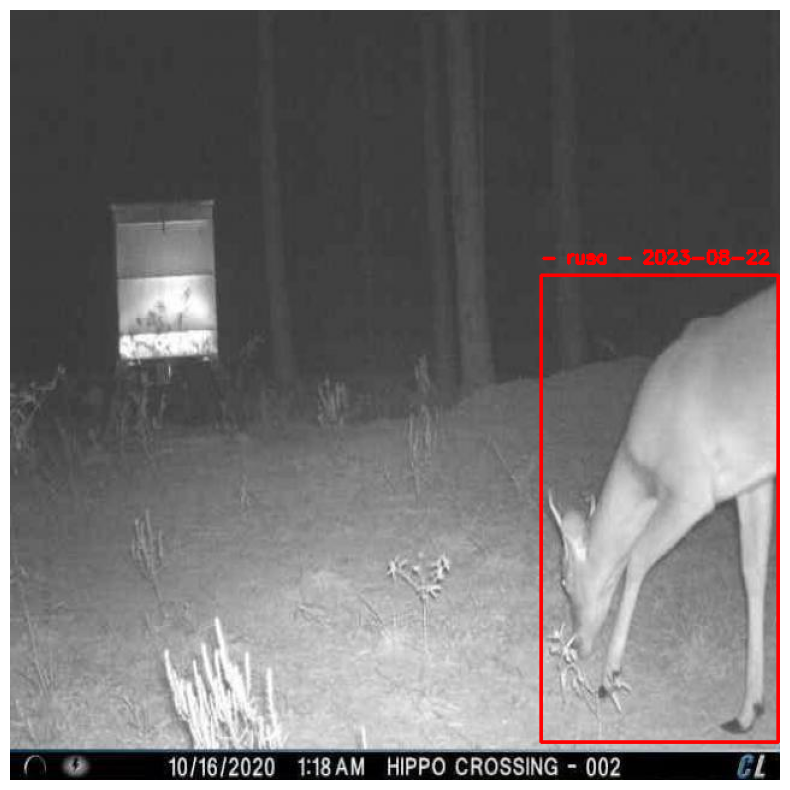

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

# Helper function to display an image with bounding boxes
def display_image_with_boxes(image_path, labels_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load bounding box labels
    with open(labels_path, 'r') as file:
        labels = file.readlines()

    for label in labels:
        class_id, x_center, y_center, width, height = map(float, label.split())
        h, w, _ = image.shape
        x1 = int((x_center - width / 2) * w)
        y1 = int((y_center - height / 2) * h)
        x2 = int((x_center + width / 2) * w)
        y2 = int((y_center + height / 2) * h)

        # Draw bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        class_name = data_config["names"][int(class_id)]
        cv2.putText(image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Visualize a random image
image_folder = os.path.join(dataset_path, "deer-1/train/images")
label_folder = os.path.join(dataset_path, "deer-1/train/labels")
image_files = os.listdir(image_folder)

sample_image = os.path.join(image_folder, image_files[0])
sample_label = os.path.join(label_folder, image_files[0].replace(".jpg", ".txt"))
display_image_with_boxes(sample_image, sample_label)


We changed the number of the index to find different images from the data set. For example, this is the first image in the data set.

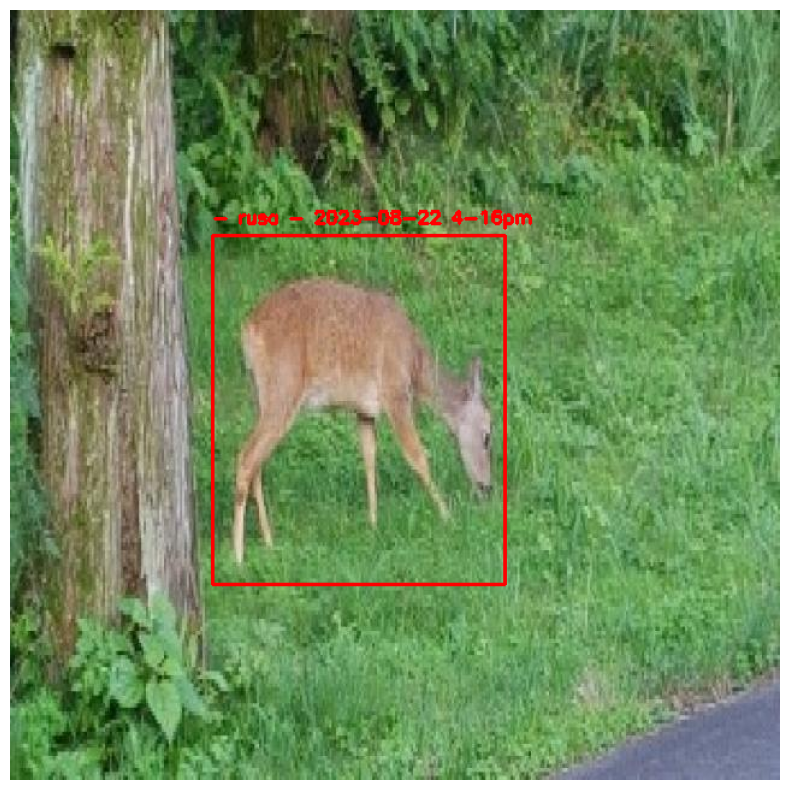

In [ ]:
sample_image = os.path.join(image_folder, image_files[1])
sample_label = os.path.join(label_folder, image_files[1].replace(".jpg", ".txt"))
display_image_with_boxes(sample_image, sample_label)

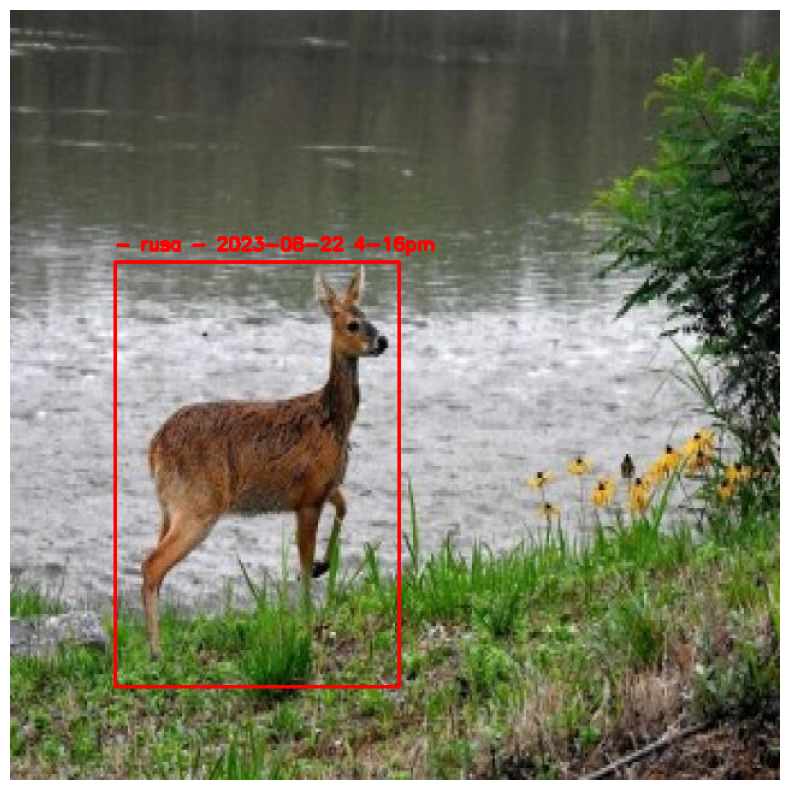

In [ ]:
sample_image = os.path.join(image_folder, image_files[2])
sample_label = os.path.join(label_folder, image_files[2].replace(".jpg", ".txt"))
display_image_with_boxes(sample_image, sample_label)

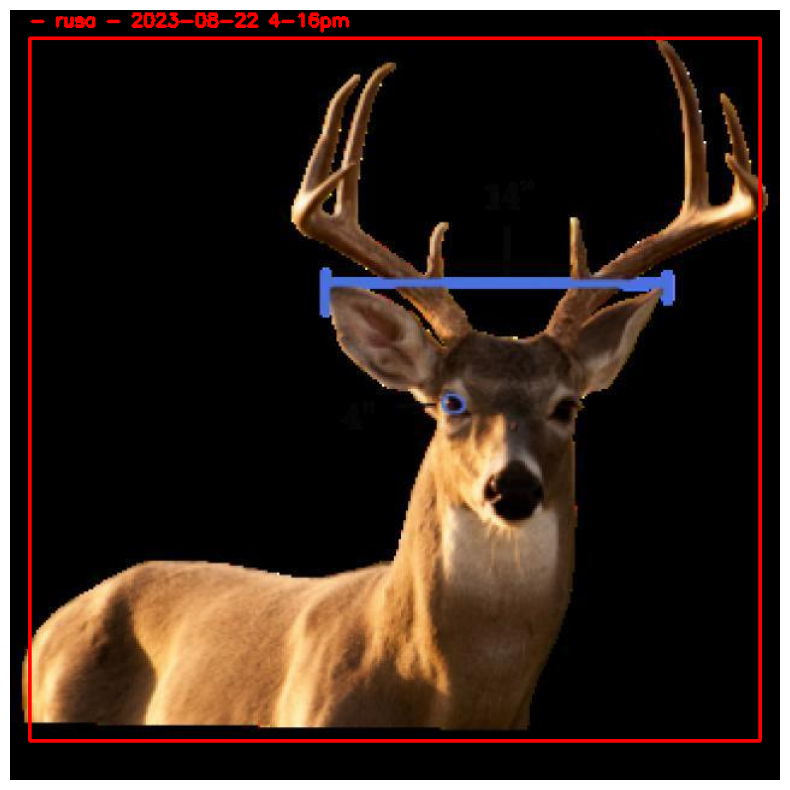

In [ ]:
sample_image = os.path.join(image_folder, image_files[4])
sample_label = os.path.join(label_folder, image_files[4].replace(".jpg", ".txt"))
display_image_with_boxes(sample_image, sample_label)

In [ ]:
dataset_path = '/content/datasets'
dataset_path

'/content/datasets'

## Model training


This code is training the model to recognize what a deer is using the data set above. The training process works off errors it might encounter while understanding what an object is. This can be compared to training a baby how to identify objects. They might make many mistakes at first but as the code continues to correct them,their accuracy will increase.

In [ ]:
# Load YOLOv5n model for object detection
model = YOLO("yolov5nu.pt")  # YOLOv5n: smaller and faster

# Train the model
model.train(
    data=os.path.join(dataset_path, "data.yaml"),  # Path to the dataset configuration file
    epochs=25,  # Fewer epochs for faster training
    imgsz=640,  # Image size
    batch=16,   # Batch size
    name="deer_detection_small"  # Experiment name
)

# Evaluate the model
results = model.val()
print("Validation Results:", results)

# Save the model
model_path = "deer_detection_small.pt"
model.save(model_path)
print(f"Model saved at {model_path}")


Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov5nu.pt, data=/content/datasets/data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=deer_detection_small6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_con

100%|██████████| 755k/755k [00:00<00:00, 20.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1760  ultralytics.nn.modules.conv.Conv             [3, 16, 6, 2, 2]              
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      4800  ultralytics.nn.modules.block.C3              [32, 32, 1]                   
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     29184  ultralytics.nn.modules.block.C3              [64, 64, 2]                   
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  3    156928  ultralytics.nn.modules.block.C3              [128, 128, 3]                 
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 93.1MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/deer-1/train/labels... 905 images, 0 backgrounds, 0 corrupt: 100%|██████████| 905/905 [00:00<00:00, 1839.11it/s]


train: New cache created: /content/datasets/deer-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/datasets/deer-1/valid/labels... 219 images, 0 backgrounds, 0 corrupt: 100%|██████████| 219/219 [00:00<00:00, 733.91it/s]


val: New cache created: /content/datasets/deer-1/valid/labels.cache
Plotting labels to runs/detect/deer_detection_small6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/deer_detection_small6
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      2.47G      1.375       2.17      1.727         17        640: 100%|██████████| 57/57 [00:22<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]

                   all        219        265      0.647      0.462       0.58      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      2.29G      1.511      1.893      1.795         26        640: 100%|██████████| 57/57 [00:18<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        219        265      0.441      0.415      0.388      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      2.28G      1.507       1.77      1.797         30        640: 100%|██████████| 57/57 [00:18<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]

                   all        219        265      0.609       0.57      0.582      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25       2.3G      1.572      1.767      1.829         27        640: 100%|██████████| 57/57 [00:18<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]

                   all        219        265      0.532      0.525      0.496      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      2.29G      1.531      1.671      1.798         26        640: 100%|██████████| 57/57 [00:18<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


                   all        219        265      0.614      0.611      0.586      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25       2.3G      1.557       1.64      1.806         26        640: 100%|██████████| 57/57 [00:18<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

                   all        219        265      0.517      0.582      0.505      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      2.28G      1.515      1.523      1.784         21        640: 100%|██████████| 57/57 [00:18<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]

                   all        219        265      0.687      0.664      0.674      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      2.29G      1.482       1.48      1.767         19        640: 100%|██████████| 57/57 [00:17<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        219        265      0.802       0.66      0.733      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      2.29G      1.464      1.446       1.75         27        640: 100%|██████████| 57/57 [00:17<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        219        265      0.802      0.671       0.72      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      2.29G      1.422      1.363      1.701         27        640: 100%|██████████| 57/57 [00:18<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

                   all        219        265      0.673      0.672      0.732      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      2.28G      1.385       1.35       1.68         20        640: 100%|██████████| 57/57 [00:17<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        219        265      0.763      0.653      0.726      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25       2.3G      1.403      1.351      1.697         31        640: 100%|██████████| 57/57 [00:18<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.60it/s]

                   all        219        265      0.832      0.736      0.775      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      2.29G      1.346      1.253      1.649         23        640: 100%|██████████| 57/57 [00:18<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]

                   all        219        265      0.767      0.796      0.804       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      2.29G      1.384      1.262      1.659         32        640: 100%|██████████| 57/57 [00:17<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        219        265      0.849      0.785       0.85      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      2.29G      1.327      1.228      1.625         26        640: 100%|██████████| 57/57 [00:18<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]

                   all        219        265      0.877      0.815      0.874      0.485


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      2.48G      1.353      1.149      1.795          9        640: 100%|██████████| 57/57 [00:19<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]

                   all        219        265       0.92      0.857        0.9      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      2.29G      1.253     0.9966      1.707         13        640: 100%|██████████| 57/57 [00:16<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]

                   all        219        265      0.881      0.849      0.903      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      2.29G      1.264     0.9616      1.733         14        640: 100%|██████████| 57/57 [00:17<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.02it/s]


                   all        219        265      0.888      0.872      0.919      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      2.28G      1.189     0.8831      1.656         11        640: 100%|██████████| 57/57 [00:17<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        219        265        0.9      0.848      0.902      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      2.29G      1.155     0.8328      1.632         12        640: 100%|██████████| 57/57 [00:17<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]

                   all        219        265      0.931      0.891      0.926       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      2.29G      1.129     0.7878      1.592         11        640: 100%|██████████| 57/57 [00:17<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        219        265      0.936      0.879      0.931      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      2.29G      1.115     0.7705      1.594          9        640: 100%|██████████| 57/57 [00:16<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        219        265      0.923       0.86      0.924      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      2.28G      1.076     0.7605      1.559         10        640: 100%|██████████| 57/57 [00:16<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.33it/s]

                   all        219        265      0.916      0.913       0.95      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      2.29G      1.059     0.7407      1.547         10        640: 100%|██████████| 57/57 [00:17<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        219        265      0.934      0.906      0.949      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      2.29G      1.037     0.7083      1.522         12        640: 100%|██████████| 57/57 [00:17<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]


                   all        219        265      0.944      0.893      0.948      0.596

25 epochs completed in 0.150 hours.
Optimizer stripped from runs/detect/deer_detection_small6/weights/last.pt, 5.3MB
Optimizer stripped from runs/detect/deer_detection_small6/weights/best.pt, 5.3MB

Validating runs/detect/deer_detection_small6/weights/best.pt...
Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv5n summary (fused): 193 layers, 2,503,139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


                   all        219        265      0.916      0.913       0.95      0.603
Speed: 0.4ms preprocess, 2.2ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs/detect/deer_detection_small6
Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv5n summary (fused): 193 layers, 2,503,139 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning /content/datasets/deer-1/valid/labels.cache... 219 images, 0 backgrounds, 0 corrupt: 100%|██████████| 219/219 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.65it/s]


                   all        219        265      0.916      0.913       0.95      0.602
Speed: 0.3ms preprocess, 6.6ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/deer_detection_small62
Validation Results: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79c354b64b20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003

FileNotFoundError: 213.jpg does not exist

## Model Inference

We are testing the code to see how well it can identify the deer through the inference process. An example is shown below with the annotations around an image that isn't part of a data set but instead a picture of a deer that the user inputted.

In [ ]:
# Perform inference on new images
inference_results = model.predict("213.jpg", save=True)
print("Inference Results:", inference_results)


image 1/1 /content/213.jpg: 608x640 1 - rusa - 2023-08-22 4-16pm, 17.4ms
Speed: 6.7ms preprocess, 17.4ms inference, 2.8ms postprocess per image at shape (1, 3, 608, 640)
Results saved to runs/detect/deer_detection_small64
Inference Results: [ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: '- rusa - 2023-08-22 4-16pm'}
obb: None
orig_img: array([[[  6,  44,  32],
        [  9,  48,  33],
        [  9,  52,  37],
        ...,
        [ 35, 115,  92],
        [ 37, 119,  96],
        [ 40, 122,  99]],

       [[  7,  45,  33],
        [  7,  48,  33],
        [  9,  52,  37],
        ...,
        [ 35, 115,  92],
        [ 39, 119,  96],
        [ 39, 121,  98]],

       [[  6,  46,  34],
        [  6,  49,  34],
        [  7,  52,  36],
        ...,
        [ 35, 115,  92],
        [ 38, 118,  95],
        [ 39, 119,  96]],

       ...,

       [[ 89, 170, 151],
        [ 89, 174, 154],
   


image 1/1 /content/213.jpg: 608x640 1 - rusa - 2023-08-22 4-16pm, 11.2ms
Speed: 3.5ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)


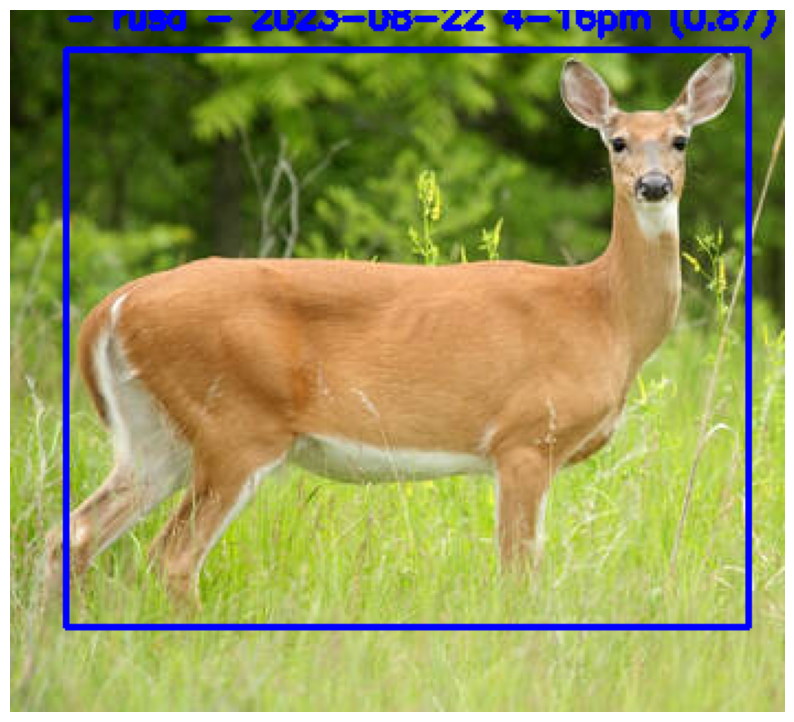

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Function to visualize inference results
def visualize_results(results):
    # Load the original image
    img = results[0].orig_img

    # Access bounding box data
    boxes = results[0].boxes
    xyxy = boxes.xyxy.cpu().numpy()  # Bounding box coordinates
    conf = boxes.conf.cpu().numpy()  # Confidence scores
    cls = boxes.cls.cpu().numpy()  # Class IDs

    # Loop through the detected boxes and annotate the image
    for i in range(len(xyxy)):
        x1, y1, x2, y2 = map(int, xyxy[i])  # Bounding box coordinates
        confidence = conf[i]  # Confidence score
        class_id = int(cls[i])  # Class ID
        label = f"{results[0].names[class_id]} ({confidence:.2f})"

        # Draw bounding box
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # Draw label
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Convert BGR to RGB for displaying with matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.show()


# Perform inference
inference_results = model.predict("213.jpg", save=False)

# Visualize results
visualize_results(inference_results)


## Real Time Inference

We borrowed code from the google colab to get access to a camera. We are now using the code to annotate an image in real time taken from a camera instead of using downloaded images. This is the final step to prove that the model can identify whether or not something is a deer in real time.

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
import random
import string
from IPython.display import display, Image


# Function to generate a random filename
def generate_random_filename(extension=".jpg"):
    random_name = ''.join(random.choices(string.ascii_letters + string.digits, k=8))
    return f"{random_name}{extension}"

# Function to take a photo (assuming the take_photo function exists)
def take_photo_and_detect():
    try:
        # Generate a random filename for the photo
        filename = generate_random_filename()

        # Take a photo
        filename = take_photo(filename=filename, quality=0.8)  # Ensure `take_photo` is implemented
        print('Photo saved as:', filename)

        # Display the captured image
        display(Image(filename))

        # Perform inference
        inference_results = model.predict(filename, save=False)

        # Visualize results
        visualize_results(inference_results)

    except Exception as err:
        print("Error capturing photo or performing detection:", str(err))


Error capturing photo or performing detection: name 'take_photo' is not defined


<IPython.core.display.Javascript object>

Photo saved as: o7XBetF5.jpg


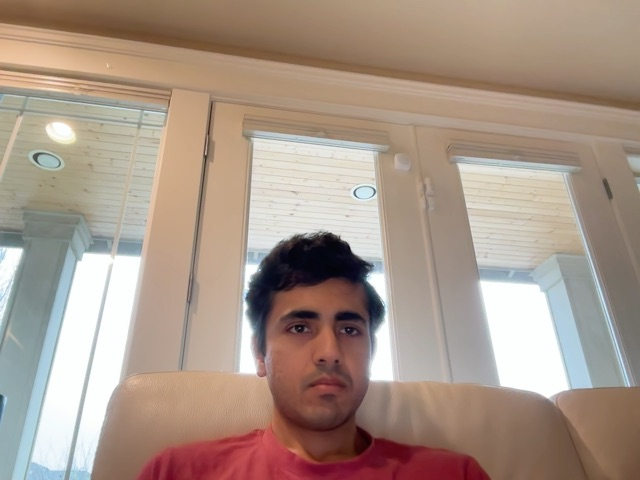


image 1/1 /content/o7XBetF5.jpg: 480x640 2 - rusa - 2023-08-22 4-16pms, 16.1ms
Speed: 1.9ms preprocess, 16.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


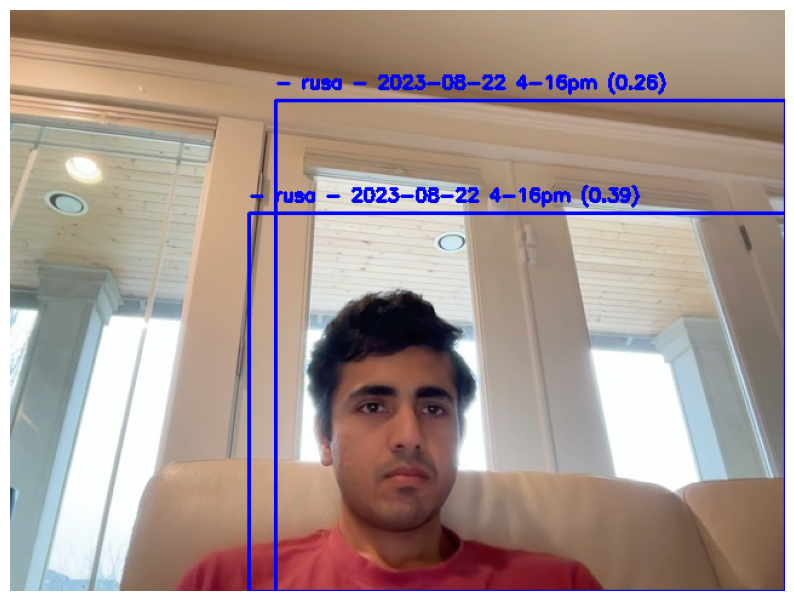

In [ ]:
# Run the photo capture and detection
take_photo_and_detect()

<IPython.core.display.Javascript object>

Photo saved as: gIRHYH7L.jpg


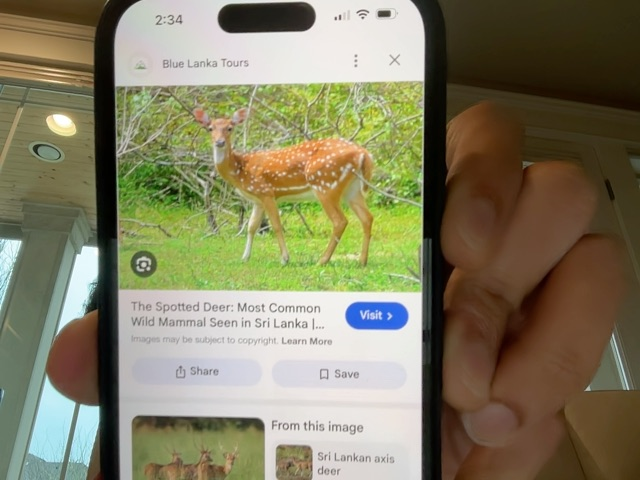


image 1/1 /content/gIRHYH7L.jpg: 480x640 2 - rusa - 2023-08-22 4-16pms, 17.6ms
Speed: 4.2ms preprocess, 17.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


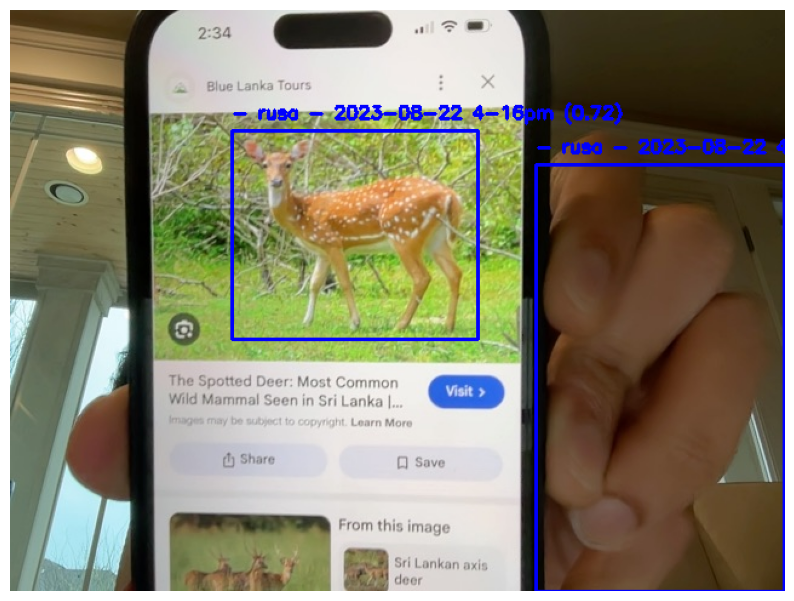

In [ ]:
# Run the photo capture and detection
take_photo_and_detect()

<IPython.core.display.Javascript object>

Photo saved as: LODfU250.jpg


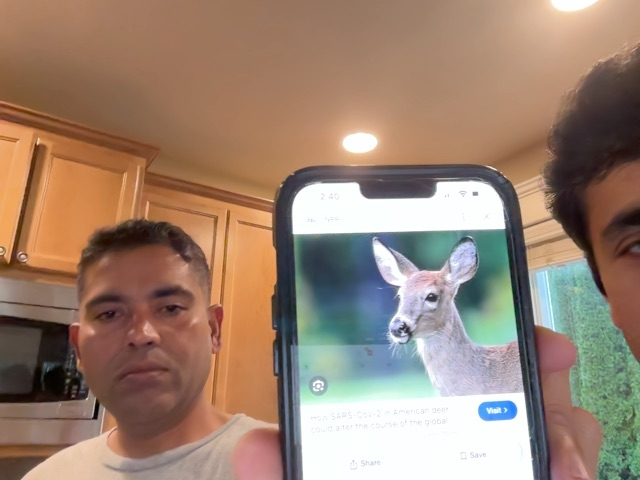


image 1/1 /content/LODfU250.jpg: 480x640 3 - rusa - 2023-08-22 4-16pms, 22.2ms
Speed: 1.9ms preprocess, 22.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


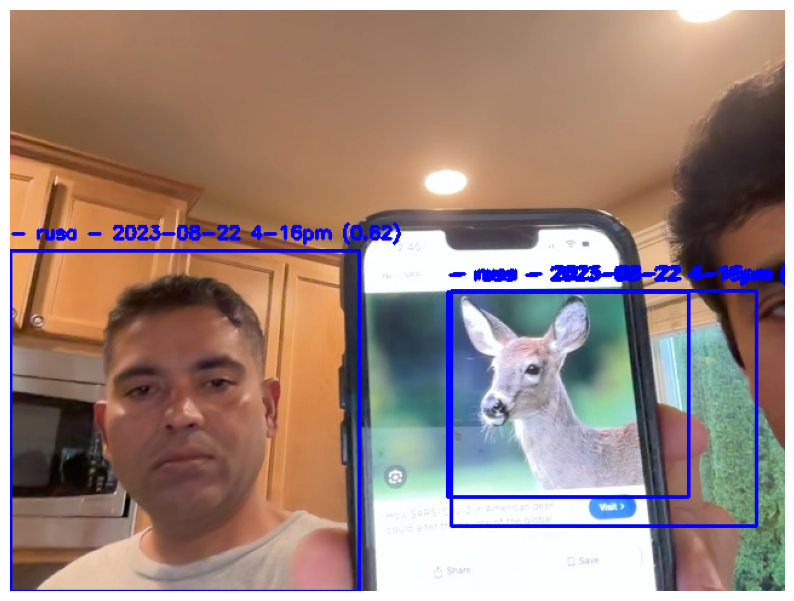

In [ ]:
# Run the photo capture and detection
take_photo_and_detect()

<IPython.core.display.Javascript object>

Photo saved as: 35HyRrY0.jpg


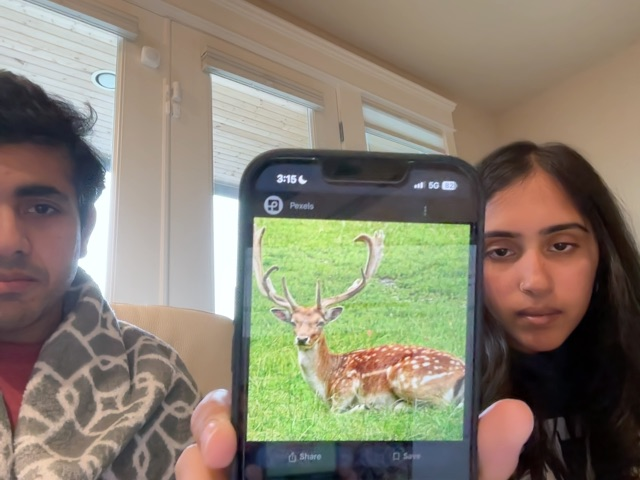


image 1/1 /content/35HyRrY0.jpg: 480x640 2 - rusa - 2023-08-22 4-16pms, 20.3ms
Speed: 9.8ms preprocess, 20.3ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 640)


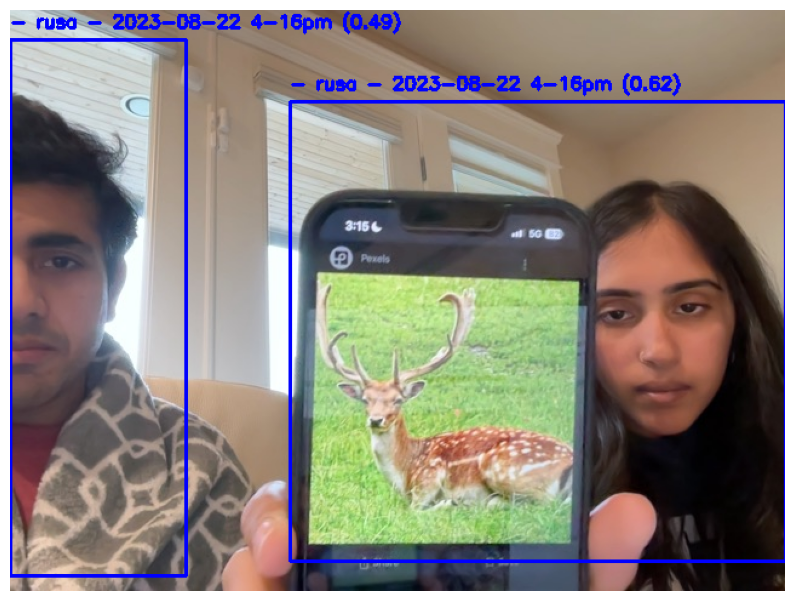

In [ ]:
take_photo_and_detect()

## Next Steps

The next steps would be to make the model more accurate.We can figure out the current accuracy by using a final evaluation by recording the data from multiple different deer images. Additionally we can change it so it can be used on various different cameras. Finally we need to figure out a way to eliminate the issue of the deers eating the flowers such as blasting a noise to send them away after they are identified.